<a href="https://colab.research.google.com/github/rpimaster/OAI/blob/main/02-autoencoder/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.Sigmoid(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 3, 3)),
            nn.ConvTranspose2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # apply encoder
        features = self.encoder(x)
        # apply decoder
        return self.decoder(features)
    def __str__(self):
        return str(self.encoder)+str(self.decoder)

In [4]:
autoencoder = Autoencoder()

In [5]:
!wget http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
model_name = 'pytorch_mnist_autoencoder_model.pth'
#from google.colab import files
#print('upload',model_name)
#files.upload()
autoencoder.load_state_dict(torch.load(model_name, map_location=device))

--2025-11-05 15:41:55--  http://agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving agentspace.org (agentspace.org)... 62.168.101.9
Connecting to agentspace.org (agentspace.org)|62.168.101.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth [following]
--2025-11-05 15:41:56--  https://www.agentspace.org/download/pytorch_mnist_autoencoder_model.pth
Resolving www.agentspace.org (www.agentspace.org)... 62.168.101.9
Connecting to www.agentspace.org (www.agentspace.org)|62.168.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52651 (51K)
Saving to: ‘pytorch_mnist_autoencoder_model.pth’

pytorch_mnist_autoe 100%[===================>]  51.42K   228KB/s    in 0.2s    

2025-11-05 15:41:57 (228 KB/s) - ‘pytorch_mnist_autoencoder_model.pth’ saved [52651/52651]



<All keys matched successfully>

In [6]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_features, num_classes, num_hidden=512):
        super().__init__()
        self.encoder = encoder
        self.perceptron = nn.Sequential(
            nn.Linear(num_features,num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden,num_classes),
        )
    def forward(self, x):
        features = self.encoder(x)
        logits = self.perceptron(features)
        if self.training:
            return logits
        else:
            return F.softmax(logits, dim=1)

In [7]:
# make encoder non-trainable
print(f"number of trainable parameters: {sum(p.numel() for p in autoencoder.encoder.parameters() if p.requires_grad)}")

for param in autoencoder.encoder.parameters():
    param.requires_grad = False

print(f"number of trainable parameters: {sum(p.numel() for p in autoencoder.encoder.parameters() if p.requires_grad)}")

number of trainable parameters: 5392
number of trainable parameters: 0


In [8]:
# create classifier
model = Classifier(autoencoder.encoder,72,10).to(device)

In [9]:
# create train and test dataloader
batch_size = 512
train_loader = DataLoader(datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


In [10]:
# Define loss funcion
criterion = nn.CrossEntropyLoss()

In [11]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# scheduler
step_size = 16
gamma = 0.7
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [13]:
# training
history_loss = []
history_acc = []
history_test_acc = []
epoch = 0

In [14]:
def train(num_epochs):
    global epoch
    for _ in range(num_epochs):
        # change model in training mood
        model.train()

        # to record loss and accuracy
        batch_loss = []
        total_train = 0
        correct_train = 0

        for batch, (x_train, y_train) in enumerate(train_loader):

            # send data to device
            input = x_train.to(device)

            # reset parameters gradient to zero
            optimizer.zero_grad()

            # forward pass to the model
            output = model(input)

            # categorization
            expected_output = y_train.to(device)

            # cross entropy loss
            loss = criterion(output, expected_output)

            # find gradients
            loss.backward()
            # update parameters using gradients
            optimizer.step()

            # recording loss
            batch_loss.append(loss.item())

            # recording accuracy
            total_train += output.shape[0]
            correct_train += torch.argmax(output,dim=1).to('cpu').eq(y_train).sum().item()

        epoch_loss = np.average(batch_loss)
        epoch_acc = (100.0 * correct_train) / total_train

        history_loss.append(epoch_loss)
        history_acc.append(epoch_acc)

        total_test = 0
        correct_test = 0

        model.eval()

        for batch, (x_test, y_test) in enumerate(test_loader):

            # send data to device
            input = x_test.to(device)

            # forward pass to the model
            with torch.no_grad():
                output = model(input)

            # recording accuracy
            total_test += output.shape[0]
            correct_test += torch.argmax(output,dim=1).to('cpu').eq(y_test).sum().item()

        test_acc = (100.0 * correct_test) / total_test

        history_test_acc.append(test_acc)

        print(f'Epoch: {epoch} Loss: {epoch_loss:.6f} Accuracy: {epoch_acc:.4f} Test accuracy: {test_acc:.4f} Learning Rate: {scheduler.get_last_lr()[0]:.7f}')
        scheduler.step()
        epoch += 1

In [15]:
# training
num_epochs = 40
print(f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(72*512+512+10*512+10)
train(num_epochs)

number of trainable parameters: 42506
42506
Epoch: 0 Loss: 1.711787 Accuracy: 60.9150 Test accuracy: 77.3300 Learning Rate: 0.0010000
Epoch: 1 Loss: 0.804858 Accuracy: 81.5250 Test accuracy: 83.8900 Learning Rate: 0.0010000
Epoch: 2 Loss: 0.562396 Accuracy: 85.5467 Test accuracy: 86.1700 Learning Rate: 0.0010000
Epoch: 3 Loss: 0.465674 Accuracy: 87.6317 Test accuracy: 87.4100 Learning Rate: 0.0010000
Epoch: 4 Loss: 0.413102 Accuracy: 88.6900 Test accuracy: 88.0400 Learning Rate: 0.0010000
Epoch: 5 Loss: 0.379834 Accuracy: 89.3283 Test accuracy: 88.7200 Learning Rate: 0.0010000
Epoch: 6 Loss: 0.356832 Accuracy: 89.8300 Test accuracy: 89.4900 Learning Rate: 0.0010000
Epoch: 7 Loss: 0.339856 Accuracy: 90.2083 Test accuracy: 90.0400 Learning Rate: 0.0010000
Epoch: 8 Loss: 0.326736 Accuracy: 90.4950 Test accuracy: 90.5200 Learning Rate: 0.0010000
Epoch: 9 Loss: 0.316158 Accuracy: 90.7400 Test accuracy: 90.9200 Learning Rate: 0.0010000
Epoch: 10 Loss: 0.307298 Accuracy: 90.9300 Test accuracy

In [16]:
def plot_history():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
    # Loss curve
    axes[0].plot(history_loss, 'r', linewidth=3.0)
    axes[0].set_title('Loss Curve', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(['Training Loss'], fontsize=12)
    # Accuracy curves
    axes[1].plot(history_acc, 'r', linewidth=3.0)
    axes[1].plot(history_test_acc, 'b', linewidth=3.0)
    axes[1].set_title('Accuracy Curves', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.tight_layout()
    plt.show()

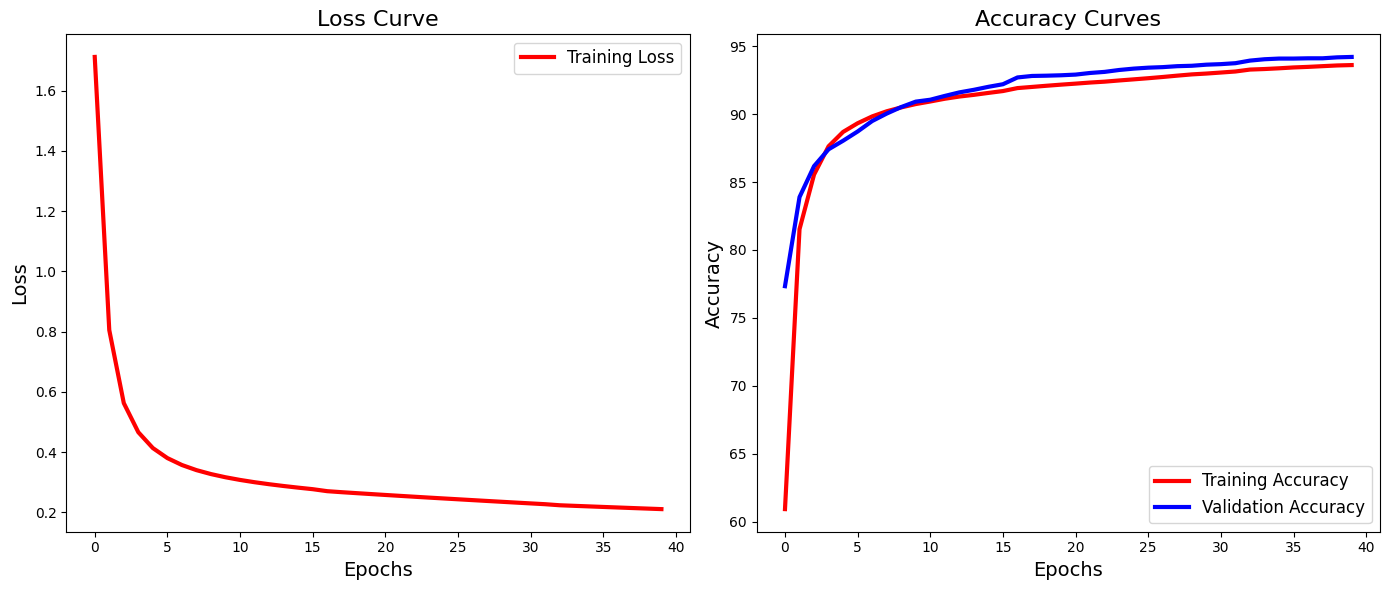

In [17]:
plot_history()

In [18]:
# make encoder trainable
for param in model.encoder.parameters():
    param.requires_grad = True

In [19]:
# fine tunning
history_loss = []
history_acc = []
history_test_acc = []
epoch = 0
print(f"number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

number of trainable parameters: 47898


In [20]:
# fine tunning
num_epochs = 200
train(num_epochs)

Epoch: 0 Loss: 0.188972 Accuracy: 94.2583 Test accuracy: 95.0100 Learning Rate: 0.0004900
Epoch: 1 Loss: 0.159358 Accuracy: 95.1250 Test accuracy: 95.5600 Learning Rate: 0.0004900
Epoch: 2 Loss: 0.140235 Accuracy: 95.7267 Test accuracy: 96.0500 Learning Rate: 0.0004900
Epoch: 3 Loss: 0.126282 Accuracy: 96.1783 Test accuracy: 96.4800 Learning Rate: 0.0004900
Epoch: 4 Loss: 0.114988 Accuracy: 96.4750 Test accuracy: 96.6700 Learning Rate: 0.0004900
Epoch: 5 Loss: 0.105773 Accuracy: 96.7583 Test accuracy: 96.9600 Learning Rate: 0.0004900
Epoch: 6 Loss: 0.098622 Accuracy: 97.0250 Test accuracy: 97.1600 Learning Rate: 0.0004900
Epoch: 7 Loss: 0.092789 Accuracy: 97.1967 Test accuracy: 97.2900 Learning Rate: 0.0004900
Epoch: 8 Loss: 0.085649 Accuracy: 97.4050 Test accuracy: 97.4400 Learning Rate: 0.0003430
Epoch: 9 Loss: 0.081712 Accuracy: 97.5083 Test accuracy: 97.4800 Learning Rate: 0.0003430
Epoch: 10 Loss: 0.078718 Accuracy: 97.5933 Test accuracy: 97.6300 Learning Rate: 0.0003430
Epoch: 11

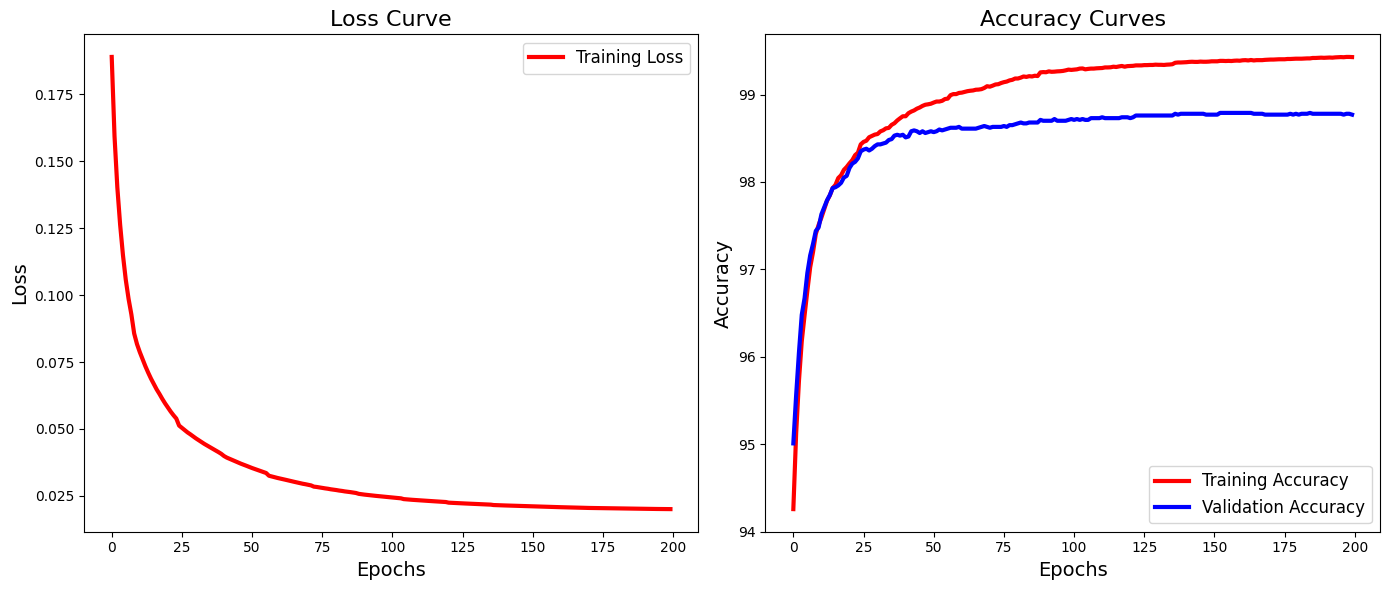

In [21]:
plot_history()

In [22]:
# Save model and weights
def save():
    torch.save(model.state_dict(), classifier_name) # weights only
    print('Saved trained model at %s ' % classifier_name)

In [23]:
classifier_name = 'mnist_classifier.pth'
save()

Saved trained model at mnist_classifier.pth 


In [24]:
# download model
from google.colab import files
files.download(classifier_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# instead of trainig, we can download its result
#!wget http://agentspace.org/download/mnist_classifier.pth
#model.load_state_dict(torch.load("mnist_classifier.pth", map_location=torch.device(device)))

In [26]:
# get few samples
test_iter = iter(test_loader)
x_sample, _ = next(test_iter)
print(x_sample.shape)

torch.Size([512, 1, 28, 28])


In [27]:
# use the model on the samples
input_images = x_sample[0:100].to(device)
output_probabilities = model(input_images).to('cpu')
output_categories = [ category.item() for category in torch.argmax(output_probabilities, dim=1) ]
print(output_categories)

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 5, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]


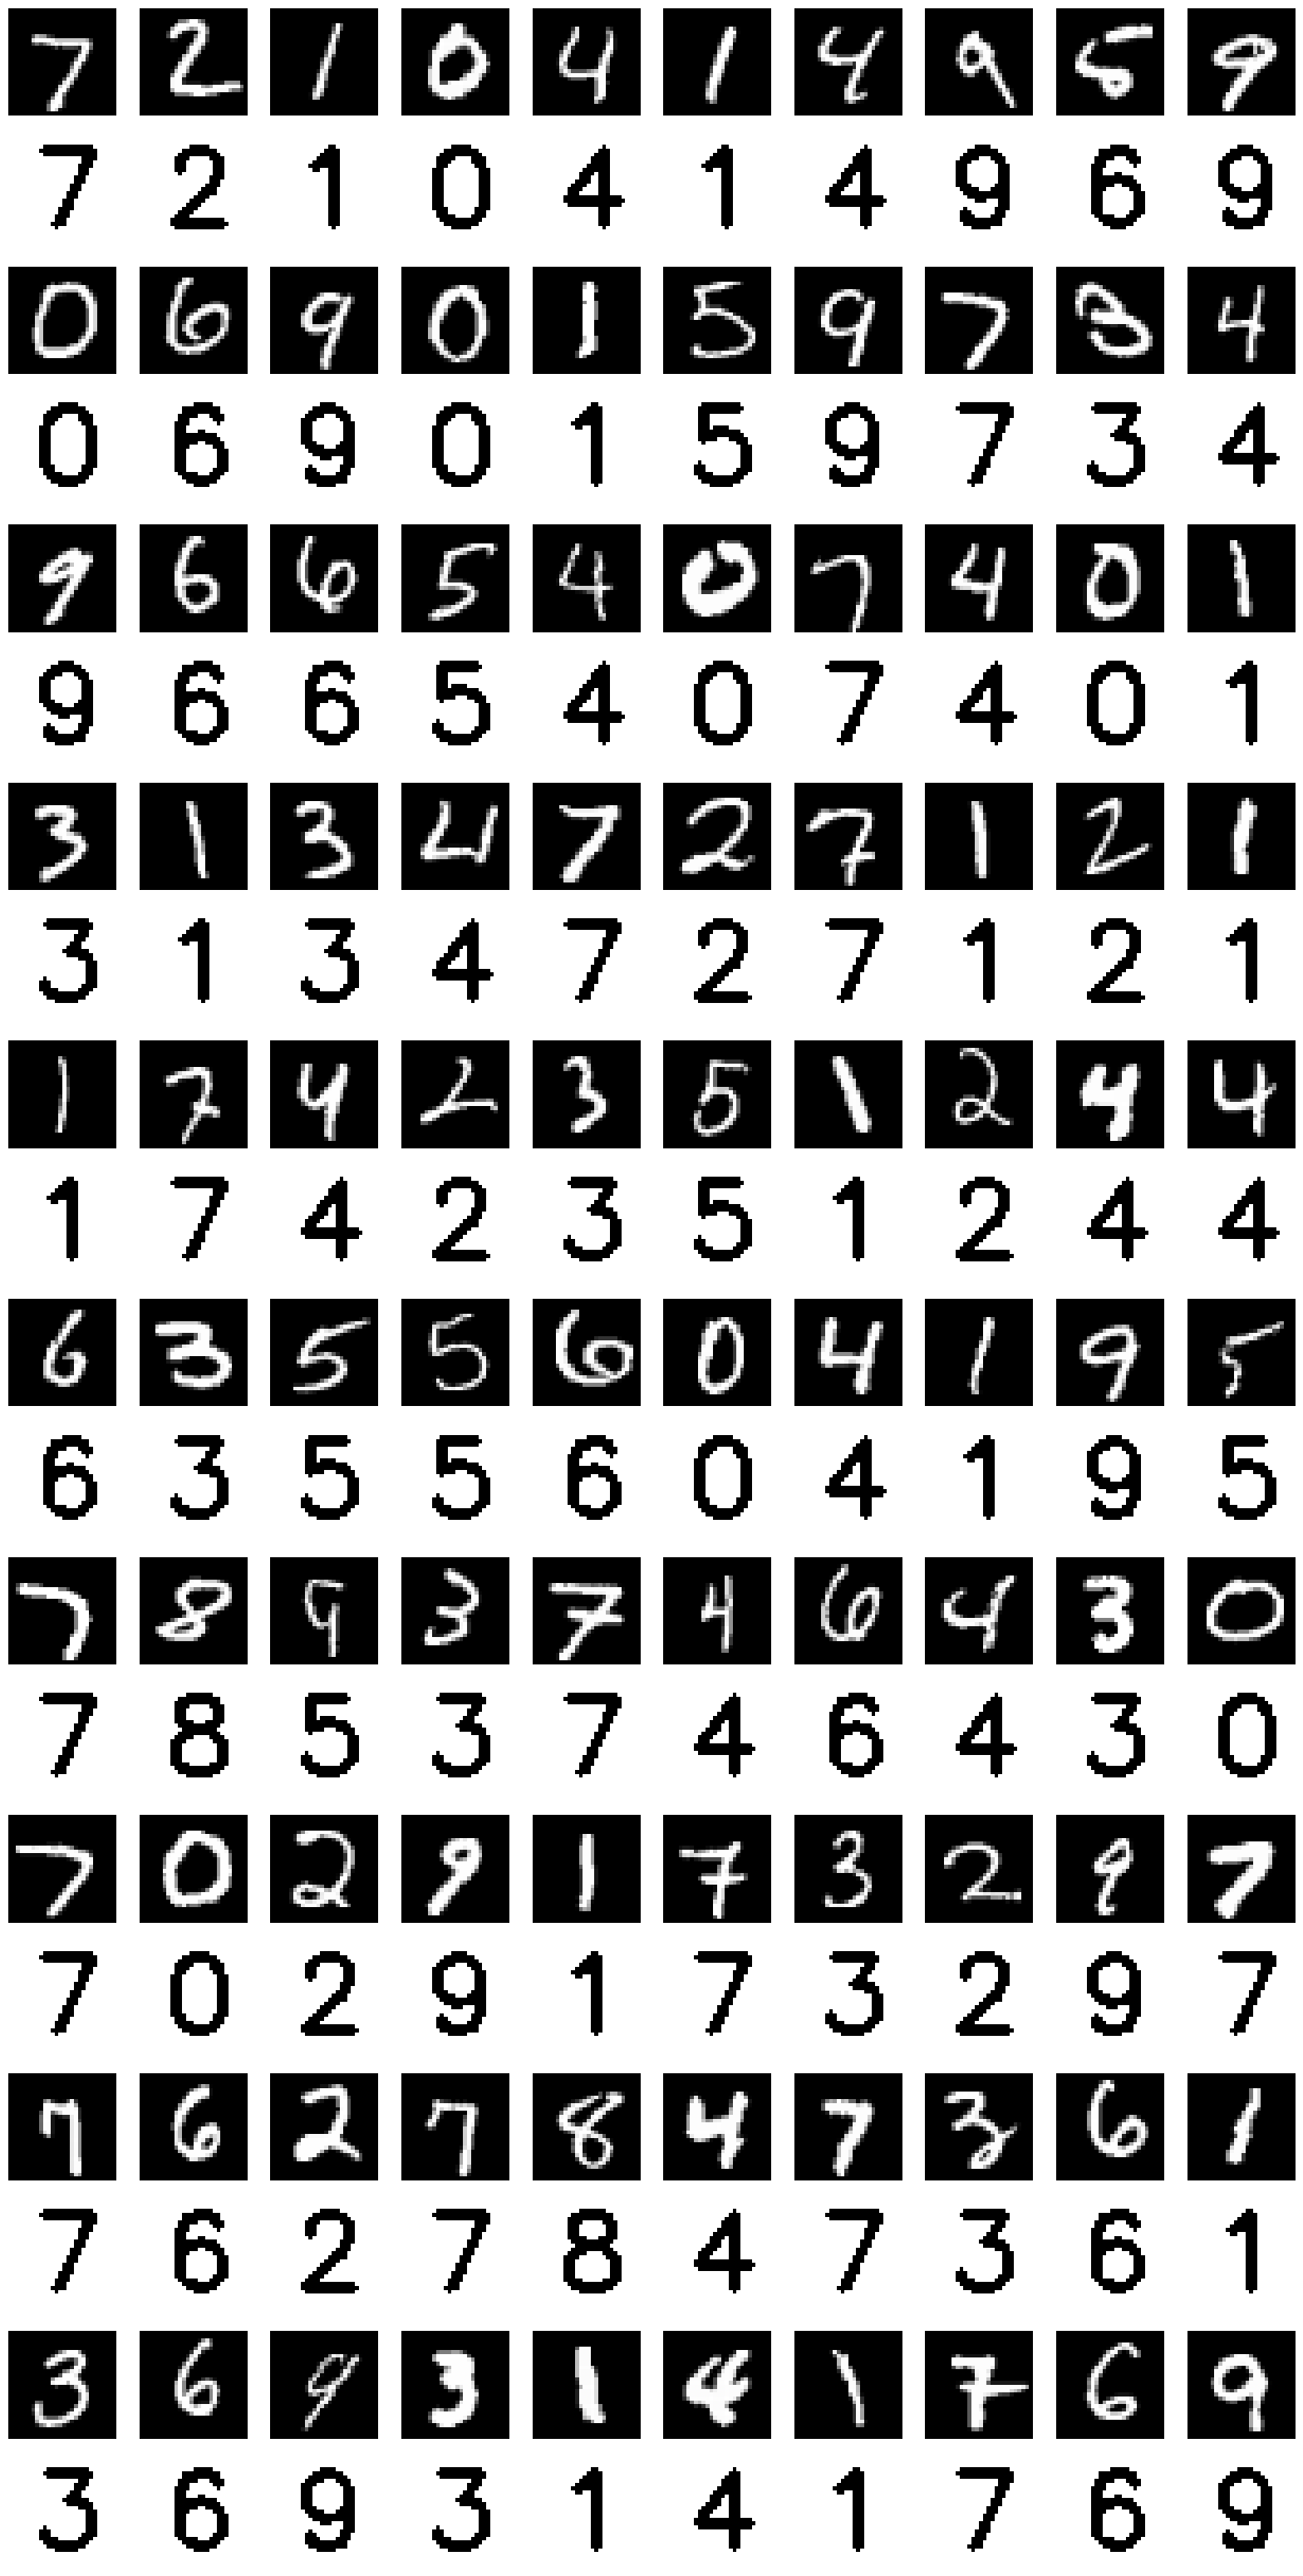

In [28]:
# show results
def render(digit):
    img = np.zeros((28, 28), dtype=np.uint8)
    cv2.putText(img, str(digit), (6, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 255, 2)
    return img

plt.figure(figsize=(20, 40))
for b in range(10):
    for i in range(10):
        input_img = (x_sample[10*b+i].squeeze(0).detach().numpy()*255).astype(np.uint8)
        plt.subplot(20, 10, 20*b+i+1)
        plt.imshow(input_img, cmap='gray')
        plt.axis('off')
        output_img = render(output_categories[10*b+i])
        plt.subplot(20, 10, 20*b+i+1+10)
        plt.imshow(~output_img, cmap='gray')
        plt.axis('off')

plt.show()